# DeepWeeds - MobileNet

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import shutil

seed = 999
def seedEverything(seed, deterministic = False):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    tf.keras.utils.set_random_seed(seed)

    if deterministic:
        tf.config.experimental.enable_op_determinism()

        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        tf.config.threading.set_inter_op_parallelism_threads(1)
        tf.config.threading.set_intra_op_parallelism_threads(1)


seedEverything(seed, True)

2024-06-04 09:18:32.456840: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 09:18:32.456964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 09:18:32.575195: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [3]:
# data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info = pd.read_csv("/kaggle/input/deepweeds/labels.csv") ## For Kaggle
data_info

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
17504,20180322-133822-1.jpg,8,Negative
17505,20180322-133832-1.jpg,8,Negative
17506,20180322-133840-1.jpg,8,Negative
17507,20180322-133850-1.jpg,8,Negative


In [4]:
data_info[['Species','Label']].groupby(by='Species').count().T

Species,Chinee apple,Lantana,Negative,Parkinsonia,Parthenium,Prickly acacia,Rubber vine,Siam weed,Snake weed
Label,1125,1064,9106,1031,1022,1062,1009,1074,1016


In [5]:
label2id = data_info[['Species','Label']].groupby(by='Species').min().to_dict()['Label']
id2label = {label2id[i]:i for i in label2id}
id2label

{0: 'Chinee apple',
 1: 'Lantana',
 8: 'Negative',
 2: 'Parkinsonia',
 3: 'Parthenium',
 4: 'Prickly acacia',
 5: 'Rubber vine',
 6: 'Siam weed',
 7: 'Snake weed'}

In [6]:
low_data_labels = data_info[data_info['Species'] != "Negative"]['Label'].unique() ## labels with very low data
low_data_labels

array([0, 1, 7, 6, 4, 3, 5, 2])

# Splitting Data into Train:Valid:Test Splits (60:20:20)

In [7]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = 1 # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

# skfold = StratifiedKFold()
# kSplits = skfold.split(data_info['Filename'], y=data_info['Label'])

# for index in range(skfold.get_n_splits()):
#     train_index, test_index = next(kSplits)
#     if index == split_index:
#         break

# trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.4, random_state=seed)
# train_data = pd.DataFrame({"Filename":trax,"label":tray})

# trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=seed)
# valid_data = pd.DataFrame({"Filename":trax,"label":tray})
# test_data = pd.DataFrame({"Filename":tex,"label":tey})

Using KFold: Index 2 out of 5 folds
-------------------------------------------------



In [8]:
train_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/train_subset{}.csv'.format(split_index)) ## for GoogleColab
train_data.rename(columns={"Label":"label"}, inplace=True)

valid_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/val_subset{}.csv'.format(split_index)) ## for GoogleColab
valid_data.rename(columns={"Label":"label"}, inplace=True)
test_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/test_subset{}.csv'.format(split_index)) ## for GoogleColab
test_data.rename(columns={"Label":"label"}, inplace=True)

print("Is There Duplicates: ", not valid_data[valid_data['Filename'].isin(test_data['Filename'])].empty)
print("Train Data\n--------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("Validation Data\n--------\n",valid_data.groupby(by='label').count().T, "\tTotal:", valid_data.shape)
print("Test Data\n--------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  676  637  619  613  637  605  644  610  5463 	Total: (10504, 2)
Validation Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  213  206  204  212  202  215  203  1822 	Total: (3502, 2)
Test Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  213  206  205  213  202  215  203  1821 	Total: (3503, 2)


# Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators) - works in tandem with "organize_data_to_directory"
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats, calcFalseRate)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)



In [9]:
from tqdm.auto import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0,oversampling_labels=[]):
    for index, row in tqdm(data_info.iterrows()):
        filename = row['Filename']
        label = row['label']

        source = os.path.join(source_dir,filename)

        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)

            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [10]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def prediction_argmax(prediction, rand_guess=1):
    prediction = np.asarray(prediction)
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def calcFalsePositiveRate(a_label, p_label, label_names=None, n_class=None):
    if n_class is None:
        n_class = len(np.unique(a_label))
    conf_mat = tf.math.confusion_matrix(a_label, p_label, num_classes=n_class).numpy()

    false_rate = []
    total = len(a_label)
    for i in range(n_class):
        tP = conf_mat[i][i]
        fN = np.sum(conf_mat[i,:]) - tP

        fP = np.sum(conf_mat[:,i]) - tP
        tN = total - (tP + fN + fP)

        fP_Rate = fP/(tN+fP)
        # fN_Rate = fN/(tP+fN)
        accuracy = tP / (tP+fN)

        false_rate.append((fP_Rate,accuracy))

    false_rate = pd.DataFrame(false_rate, columns=["False Positive Rate", "Accuracy"], index=label_names)
    return false_rate

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Evaluation Metrics\n=================================\n")
    #     print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    #     print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    #     print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    #     print("accuracy_Score",accuracy_score(actual_labels,prediction))

    label_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(actual_labels, prediction,digits=5, target_names=label_names))
    print()
    print(calcFalsePositiveRate(actual_labels, prediction, label_names = label_names))
    print()
    print("Confusion Matrix\n=================================\n")
    n_class = np.unique(actual_labels).shape[0]
    cmd = ConfusionMatrixDisplay.from_predictions(
        actual_labels, prediction,
        display_labels=label_names,
        xticks_rotation=45 #'vertical'
    )
    #cmd.plot()
    plt.show()

def eval_model(model, data_gen, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data_gen)

    print("model.predict")
    actual_labels = []
    pred_prob = []
    for batch in tqdm(data_gen):
        actual_labels.extend([np.argmax(z) for z in batch[1]])
        pred_prob.extend(list(model(batch[0], training=False)))

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob


def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    if 'peaks' in history:
        peaks = history['peaks']
    else:
        _min = np.argmin(val_loss)
        peaks = [_min]

    epochs = range(len(acc))
    print("Total Epochs:",epochs)

    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    p_value = [val_acc[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    p_value = [val_loss[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Creating Dateset ImageGenerator

In [11]:
IMG_SIZE=(256,256,3)
oversampling = 0 # How many times are we gonna over sample

if oversampling:
    print("Oversampling",oversampling,"times for labels",low_data_labels)
else:
    print("No OverSampling")

# base_dir = '/content/dataset_9c' ## For GoogleColab
# input_dir = '/content/images' ## For GoogleColab

input_dir = "/kaggle/input/deepweeds/images" ## For Kaggle
base_dir = "/kaggle/working/deepweeds_9c" ## For Kaggle

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=oversampling, oversampling_labels=low_data_labels)

# ## Organizing Validation Data
organize_data_to_directory(valid_data, source_dir=input_dir, target_dir=validation_dir)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

No OverSampling


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [12]:
train_generator = getDatasetGenerators(
      train_dir,
      batch_size=32,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

validation_generator = getDatasetGenerators(
      validation_dir,
      batch_size=32,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

test_generator = getDatasetGenerators(
      test_dir,
      batch_size=32,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=False
)

Found 10504 files belonging to 9 classes.
Found 3502 files belonging to 9 classes.
Found 3503 files belonging to 9 classes.


# Sample Images

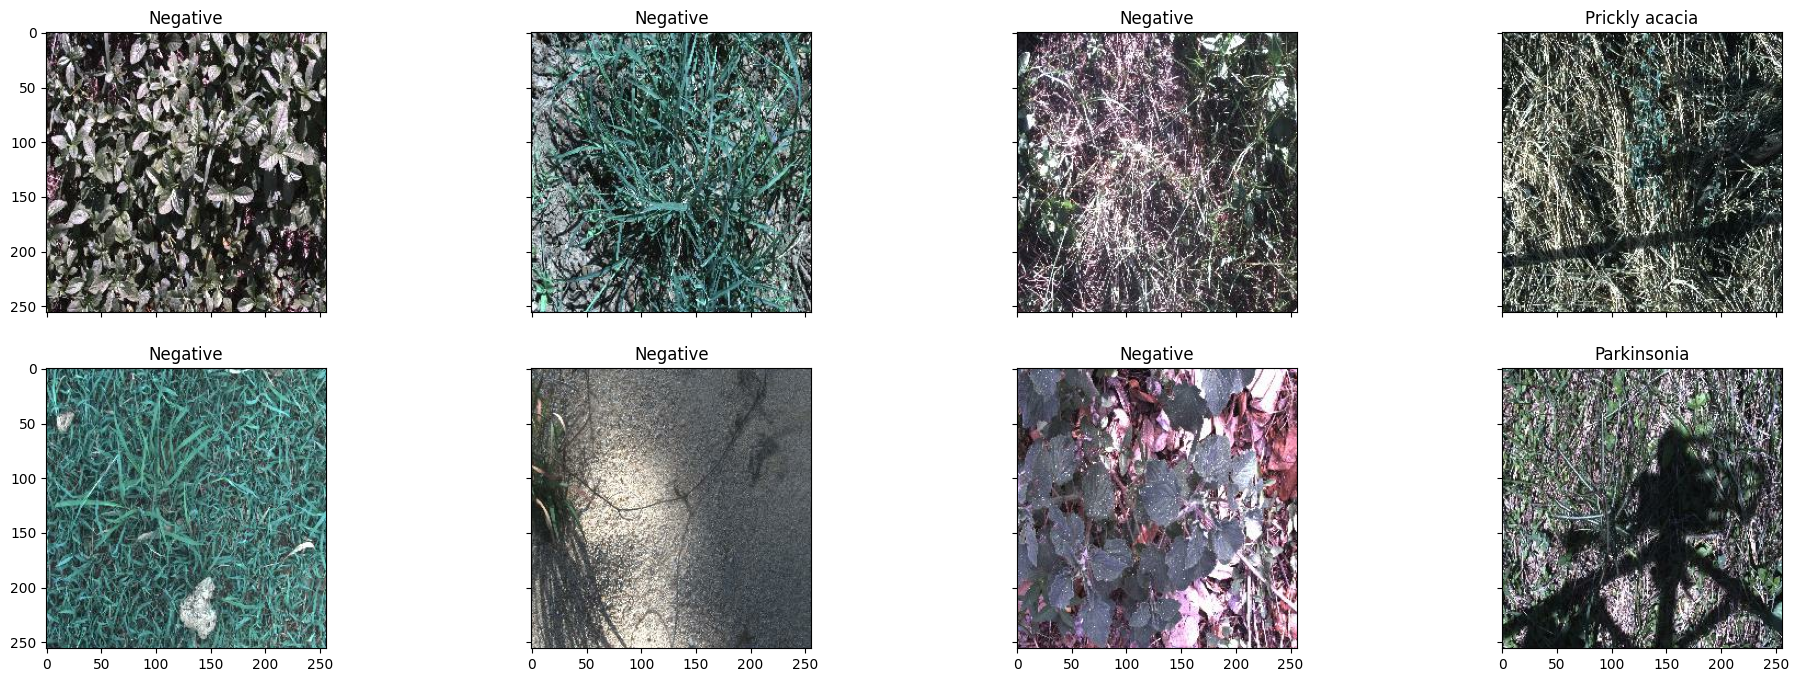

In [13]:
#image visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

for images, labels in validation_generator:
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

In [14]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPool2D, Reshape, \
                        Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Average
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid, softmax

class SpatialMaxPooling2D(tf.keras.layers.Layer):
    def __init__(self,pool_size=2,stride=None,padding='valid',data_format='channels_last', **kwargs):
        super(SpatialMaxPooling2D,self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        if stride is None:
            self.stride = self.pool_size

        self.data_format = 'channels_last' if data_format == 'channels_first' else 'channels_first'
        self.max = tf.keras.layers.MaxPool1D(self.pool_size, self.stride, padding=self.padding, data_format=self.data_format)

    def build(self,input_shape):
        self.reshape_forward = tf.keras.layers.Reshape((-1,input_shape[-1]))
        self.reshape_backward= tf.keras.layers.Reshape((input_shape[1], input_shape[2], -1))

    def call(self,x):
        x = self.reshape_forward(x)
        x = self.max(x)
        x = self.reshape_backward(x)
        return x

class SpatialAveragePooling2D(tf.keras.layers.Layer):
    def __init__(self,pool_size=2,stride=None,padding='valid',data_format='channels_last', **kwargs):
        super(SpatialAveragePooling2D,self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        if stride is None:
            self.stride = self.pool_size

        self.data_format = 'channels_last' if data_format == 'channels_first' else 'channels_first'
        self.avg = tf.keras.layers.AveragePooling1D(self.pool_size, self.stride, padding=self.padding, data_format=self.data_format)

    def build(self,input_shape):
        self.reshape_forward = tf.keras.layers.Reshape((-1,input_shape[-1]))
        self.reshape_backward= tf.keras.layers.Reshape((input_shape[1], input_shape[2], -1))

    def call(self,x):
        x = self.reshape_forward(x)
        x = self.avg(x)
        x = self.reshape_backward(x)
        return x

def AverageOfMaximums(x, max_pool_size=2, layer_num=1):
    _max = layers.MaxPooling2D(pool_size=max_pool_size,padding='same', name="Maximums_L{}".format(layer_num))(x)
    _avg = layers.GlobalAveragePooling2D(name="Average_of_Maximums_L{}".format(layer_num))(_max)
    return _avg

In [15]:
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPool2D, Reshape, \
Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Average
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid, softmax

def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """

    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros',
                           name='Dense_Squeeze_CA')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros',
                           name='Dense_Excite_CA')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)

    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel//ratio)

    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)

    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1,1,channel//ratio)

    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)

    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])



def spatial_attention(input_feature):
    kernel_size = 5

    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1

    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1

    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2

    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

In [16]:
def ModifiedSpatialAttention(input_feature, kernel_size=5, num_pooled_channel=8, layer_num = 0):
    in_shape = input_feature.shape
    #pool_size =  in_shape[-1] // num_pooled_channel

    channel_avg = layers.Dense(num_pooled_channel, name="MSA_Feature_1L{}".format(layer_num))(input_feature)
    channel_max = layers.Dense(num_pooled_channel , name='MSA_Feature_2L{}'.format(layer_num))(input_feature)


    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    concat = Concatenate(axis=3)([channel_avg, channel_max])

    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

In [17]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()


class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

# Building MobileNet Model

In [18]:
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.applications import EfficientNetV2S, ConvNeXtSmall

def augment(seed=42):
    return keras.Sequential([
        layers.RandomBrightness(0.3, (0, 1),seed=seed, name='RR_Bright'),
        # layers.RandomContrast(0.3, seed=seed, name='RR_Contr'), # can't run deterministically
        layers.RandomFlip(seed=seed, name='RR_Flip'),
        layers.RandomRotation(0.5, seed=seed, name='RR_Rot'),
        layers.RandomTranslation(0.4, 0.4, seed=seed, name='RR_Trans'),
        layers.RandomZoom(0.2, 0.2, seed=seed, name='RR_Zoom'),
        layers.GaussianDropout(0.01, seed=seed, name='RR_Gauss'),
    ], name='augment_pipeline')


def skipAugment(model):
    inputs = keras.Input(shape=IMG_SIZE)
    x = inputs
    for layer in model.layers:
        if 'augment' not in layer.name and 'input' not in layer.name:
            x = layer(x)

    model = keras.Model(inputs=inputs, outputs=x, name=model.name)
    return model

def hard_swish(x):
    relu6 = layers.ReLU(max_value=6)
    return x * (relu6(x + 3) / 6)

def MobilenetV3Base(img_size, use='S'): # use = S (small) or L (large)
    # Load the MobileNet model with weights pre-trained on ImageNet.
    if(use=='S'):
        mobilenet = MobileNetV3Small(input_shape=img_size, weights='imagenet')
    if(use=='L'):
        mobilenet = MobileNetV3Large(input_shape=img_size, weights='imagenet')
    mobilenet.trainable = True

    base_model =  keras.Model(inputs=mobilenet.layers[0].input, outputs=mobilenet.layers[-11].output, name = mobilenet.name+"_base_")
    base_model.trainable = True

    pooler = mobilenet.layers[-9]

    return base_model , pooler

def buildModel(IMG_SIZE):
    # Load the MobileNet model with weights pre-trained on ImageNet.
    base_model, pooler = MobilenetV3Base((224,224,3), use='S')
    base_model.trainable = True
    # out_dim = 1024 if "small" in base_model.name.lower() else 1280 if "large" in base_model.name.lower() else base_model.output.shape[-1]

    print("Base Model:", base_model.name)
    print(len(base_model.layers))
    
    # Define the input layer.
    inputs = keras.Input(shape=IMG_SIZE, name='input')

    # Pre-process the input.
    x = layers.Rescaling(1./255, name='PP_Rescale')(inputs)
    x = layers.Resizing(224, 224, name='PP_Resize')(x)

    x = augment(seed)(x)
    x = base_model(x, training=True)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(9, activation='softmax')(x)

    model_name = "CottonWeed15-" + base_model.name
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

    return model

In [19]:
# IMG_SIZE = (256,256,3)
# seed = 42
model = buildModel(IMG_SIZE)
model.summary()

10734624/10734624 [==============================] - 1s 0us/step
Base Model: MobilenetV3small_base_
229
Model: "CottonWeed15-MobilenetV3small_base_"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 PP_Rescale (Rescaling)      (None, 256, 256, 3)       0         
                                                                 
 PP_Resize (Resizing)        (None, 224, 224, 3)       0         
                                                                 
 augment_pipeline (Sequenti  (None, 224, 224, 3)       0         
 al)                                                             
                                                                 
 MobilenetV3small_base_ (Fu  (None, 7, 7, 576)         939120    
 nctional)                                                 

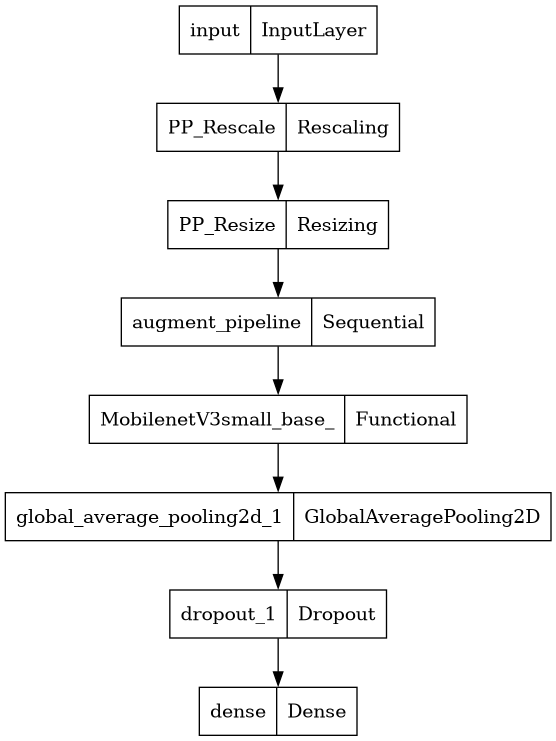

In [20]:
tf.keras.utils.plot_model(model)

# Trial 1 - FineTuning

In [21]:
from tensorflow.keras.optimizers import RMSprop, AdamW

# Constant for epochs
EPOCHS = 200

pat_es = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=pat_es, verbose=1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=3, verbose=1, min_lr=1e-6)

model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=2e-4,  weight_decay=5e-2),
          metrics=['accuracy'])
# weights = getWeightedClass(data_info, 1/3)
# weights

Epoch 1/200


I0000 00:00:1717492848.184591      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


329/329 [==============================] - 55s 76ms/step - loss: 1.3553 - accuracy: 0.5507 - val_loss: 0.9380 - val_accuracy: 0.6716 - lr: 2.0000e-04
Epoch 2/200
329/329 [==============================] - 24s 72ms/step - loss: 1.0081 - accuracy: 0.6471 - val_loss: 0.7532 - val_accuracy: 0.7324 - lr: 2.0000e-04
Epoch 3/200
329/329 [==============================] - 24s 71ms/step - loss: 0.8488 - accuracy: 0.6998 - val_loss: 0.6589 - val_accuracy: 0.7681 - lr: 2.0000e-04
Epoch 4/200
329/329 [==============================] - 24s 72ms/step - loss: 0.7551 - accuracy: 0.7337 - val_loss: 0.5504 - val_accuracy: 0.8147 - lr: 2.0000e-04
Epoch 5/200
329/329 [==============================] - 24s 72ms/step - loss: 0.6918 - accuracy: 0.7546 - val_loss: 0.4913 - val_accuracy: 0.8358 - lr: 2.0000e-04
Epoch 6/200
329/329 [==============================] - 24s 73ms/step - loss: 0.6172 - accuracy: 0.7847 - val_loss: 0.4769 - val_accuracy: 0.8352 - lr: 2.0000e-04
Epoch 7/200
329/329 [===================

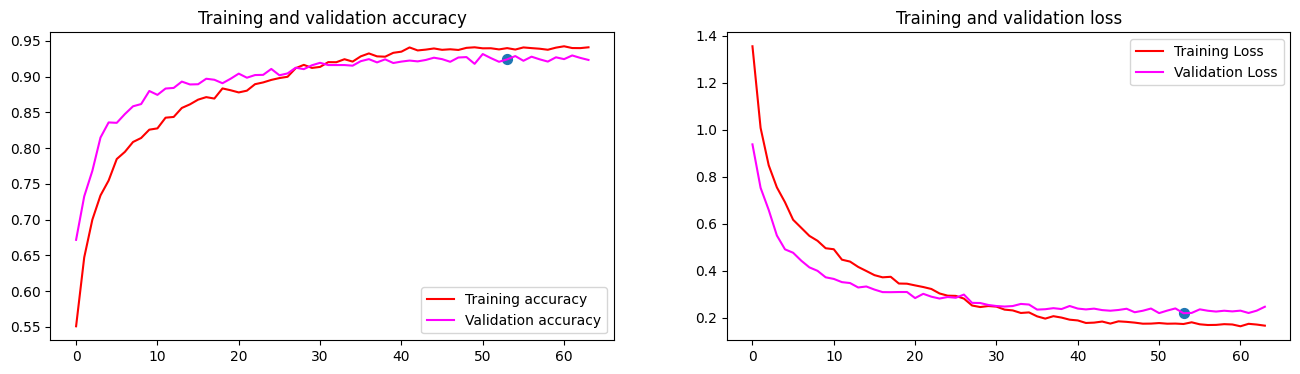

CPU times: user 40min 54s, sys: 2min 44s, total: 43min 38s
Wall time: 26min 19s


In [22]:
%%time

# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping, reduce_lr],
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history1.history)

# Evaluation

model.evaluate
110/110 [==============================] - 3s 25ms/step - loss: 0.2304 - accuracy: 0.9246
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.81982   0.80889   0.81432       225
       Lantana    0.93467   0.87324   0.90291       213
   Parkinsonia    0.96517   0.94175   0.95332       206
    Parthenium    0.92537   0.91176   0.91852       204
Prickly acacia    0.88889   0.90566   0.89720       212
   Rubber vine    0.91220   0.92574   0.91892       202
     Siam weed    0.91943   0.90233   0.91080       215
    Snake weed    0.84211   0.78818   0.81425       203
      Negative    0.94238   0.96048   0.95135      1822

      accuracy                        0.92262      3502
     macro avg    0.90556   0.89089   0.89795      3502
  weighted avg    0.92219   0.92262   0.92221      3502


                False Positive Rate  Accuracy
Chinee apple               0.012206  0.808889
Lantana                    0.003953  0.873239
Parkinsonia                0.002124  0.941748
Parthenium                 0.004548  0.911765
Prickly acacia    

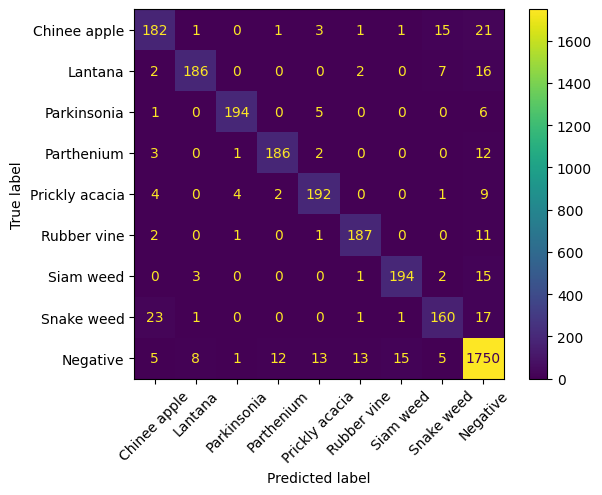

In [23]:
a, b = eval_model(model, validation_generator)

model.evaluate
110/110 [==============================] - 3s 26ms/step - loss: 3.7371 - accuracy: 0.4636
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.09489   0.05778   0.07182       225
       Lantana    0.16000   0.05634   0.08333       213
   Parkinsonia    0.29167   0.03398   0.06087       206
    Parthenium    0.16667   0.04390   0.06950       205
Prickly acacia    0.15909   0.03286   0.05447       213
   Rubber vine    0.14085   0.04950   0.07326       202
     Siam weed    0.17460   0.05116   0.07914       215
    Snake weed    0.09890   0.04433   0.06122       203
      Negative    0.52514   0.84898   0.64890      1821

      accuracy                        0.46360      3503
     macro avg    0.20131   0.13543   0.13361      3503
  weighted avg    0.34996   0.46360   0.37059      3503


                False Positive Rate  Accuracy
Chinee apple               0.037828  0.057778
Lantana                    0.019149  0.056338
Parkinsonia                0.005156  0.033981
Parthenium                 0.013645  0.043902
Prickly acacia    

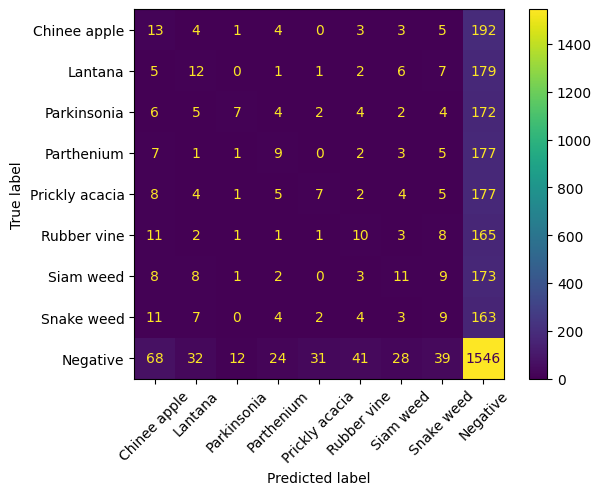

In [24]:

a, b = eval_model(model, test_generator)

# Trial 2 - Freezing Base Model

Freezing Layer MobilenetV3small_base_
Epoch 1/200
329/329 [==============================] - 19s 43ms/step - loss: 1.1178 - accuracy: 0.7195 - val_loss: 0.8936 - val_accuracy: 0.7941 - lr: 1.0000e-06
Epoch 2/200
329/329 [==============================] - 13s 40ms/step - loss: 1.1017 - accuracy: 0.7173 - val_loss: 0.8873 - val_accuracy: 0.7950 - lr: 1.0000e-06
Epoch 3/200
329/329 [==============================] - 13s 41ms/step - loss: 1.0806 - accuracy: 0.7198 - val_loss: 0.8812 - val_accuracy: 0.7961 - lr: 1.0000e-06
Epoch 4/200
329/329 [==============================] - 13s 40ms/step - loss: 1.0793 - accuracy: 0.7185 - val_loss: 0.8752 - val_accuracy: 0.7981 - lr: 1.0000e-06
Epoch 5/200
329/329 [==============================] - 13s 41ms/step - loss: 1.0927 - accuracy: 0.7193 - val_loss: 0.8693 - val_accuracy: 0.7984 - lr: 1.0000e-06
Epoch 6/200
329/329 [==============================] - 13s 40ms/step - loss: 1.0732 - accuracy: 0.7236 - val_loss: 0.8635 - val_accuracy: 0.7987 - lr: 1

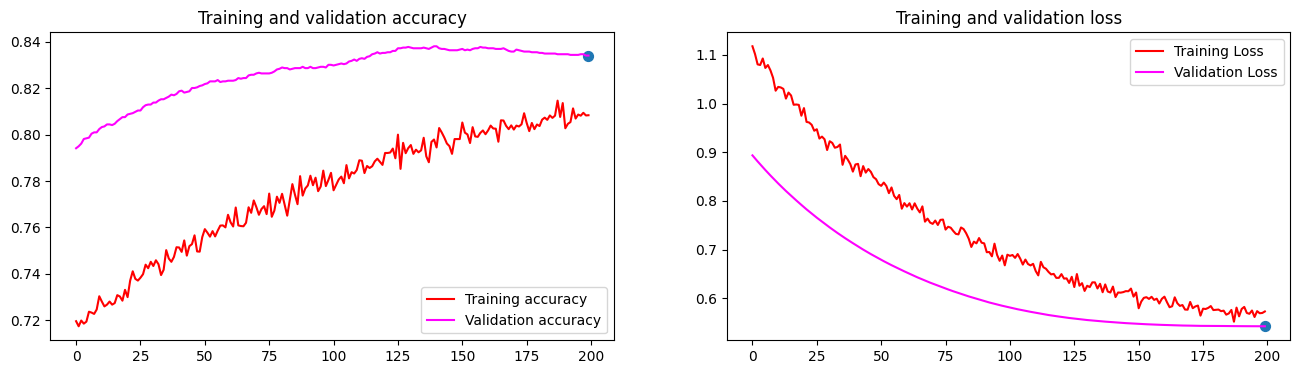

In [25]:
# weights = getWeightedClass(data_info, 1/2)
# print("Using Class-Weights",weights)

for layer in model.layers:
    if('mobilenet' in layer.name.lower()):
        print("Freezing Layer", layer.name)
        layer.trainable = False
        break

model.compile(loss='categorical_crossentropy',
  optimizer=AdamW(learning_rate=1e-6,  weight_decay=5e-4),
  metrics=['accuracy'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=3, verbose=1, min_lr=5e-7)
# Train the model
history2 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping,reduce_lr]
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history2.history)

# Accuracy / Loss Plots

Total Epochs: range(0, 264)


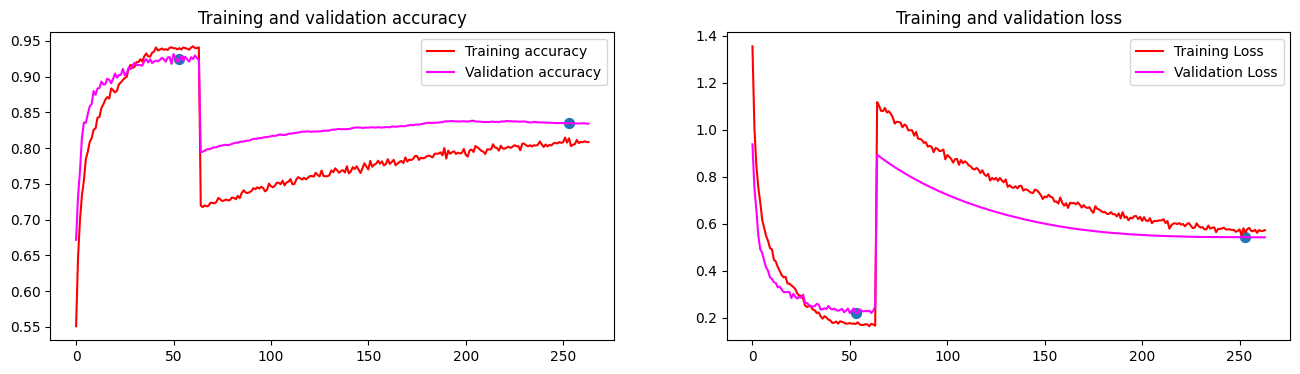

In [26]:
import copy

history = copy.deepcopy(history1.history)

for key in history:
    history[key].extend(history2.history[key])


h1len = len(history1.history['accuracy'])
h2len = len(history2.history['accuracy'])

pat_es +=1
history['peaks'] = [h1len-pat_es, (h1len+h2len)-pat_es]
history['peaks'] = [i if i>=0 else 0 for i in history['peaks']]

plot_loss_acc(history)

Total Epochs: range(0, 64)


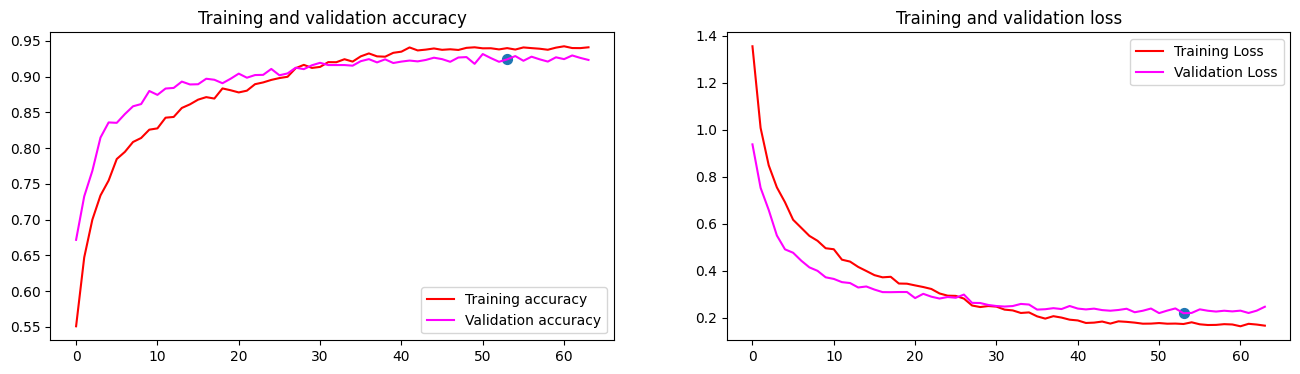

Total Epochs: range(0, 200)


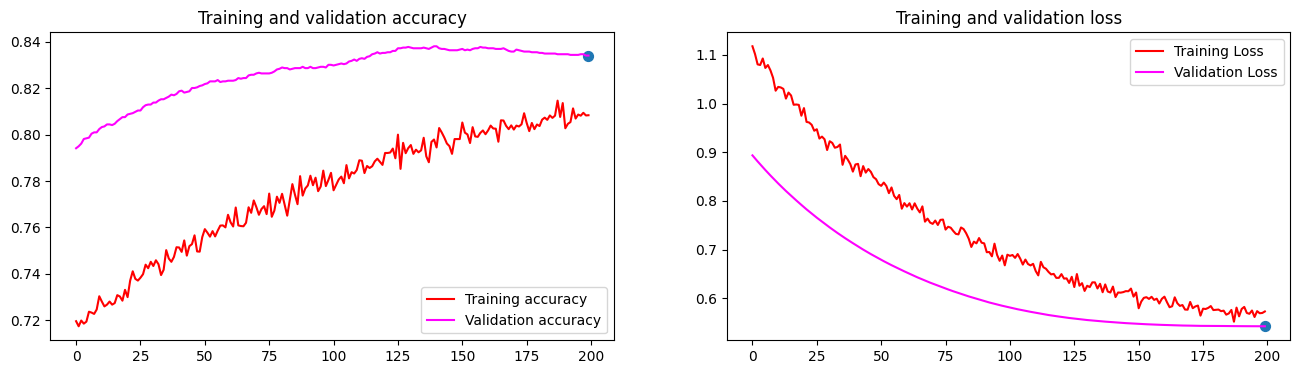

In [27]:
plot_loss_acc(history1.history)
plot_loss_acc(history2.history)

# Evaluations

model.evaluate
110/110 [==============================] - 3s 22ms/step - loss: 0.5424 - accuracy: 0.8341
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.87662   0.60000   0.71240       225
       Lantana    0.91566   0.71362   0.80211       213
   Parkinsonia    0.95105   0.66019   0.77937       206
    Parthenium    0.69565   0.78431   0.73733       204
Prickly acacia    0.70417   0.79717   0.74779       212
   Rubber vine    0.92063   0.86139   0.89003       202
     Siam weed    0.67763   0.95814   0.79383       215
    Snake weed    0.65984   0.79310   0.72036       203
      Negative    0.88865   0.89352   0.89108      1822

      accuracy                        0.83409      3502
     macro avg    0.80999   0.78461   0.78603      3502
  weighted avg    0.84640   0.83409   0.83406      3502


                False Positive Rate  Accuracy
Chinee apple               0.005798  0.600000
Lantana                    0.004257  0.713615
Parkinsonia                0.002124  0.660194
Parthenium                 0.021225  0.784314
Prickly acacia    

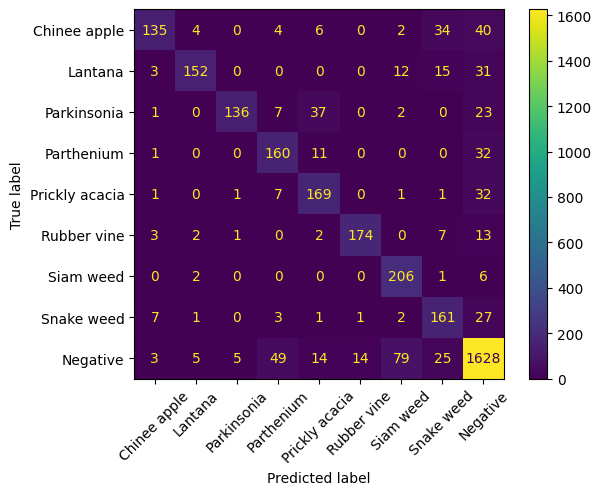

In [28]:
## Computing Positive Threshold Using Validation Dataset
a, b = eval_model(model,validation_generator)

model.evaluate
110/110 [==============================] - 3s 22ms/step - loss: 0.4849 - accuracy: 0.8424
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.91946   0.60889   0.73262       225
       Lantana    0.94048   0.74178   0.82940       213
   Parkinsonia    0.91156   0.65049   0.75921       206
    Parthenium    0.70042   0.80976   0.75113       205
Prickly acacia    0.71849   0.80282   0.75831       213
   Rubber vine    0.94241   0.89109   0.91603       202
     Siam weed    0.67657   0.95349   0.79151       215
    Snake weed    0.65414   0.85714   0.74200       203
      Negative    0.90133   0.89292   0.89710      1821

      accuracy                        0.84242      3503
     macro avg    0.81832   0.80093   0.79748      3503
  weighted avg    0.85685   0.84242   0.84295      3503


                False Positive Rate  Accuracy
Chinee apple               0.003661  0.608889
Lantana                    0.003040  0.741784
Parkinsonia                0.003943  0.650485
Parthenium                 0.021528  0.809756
Prickly acacia    

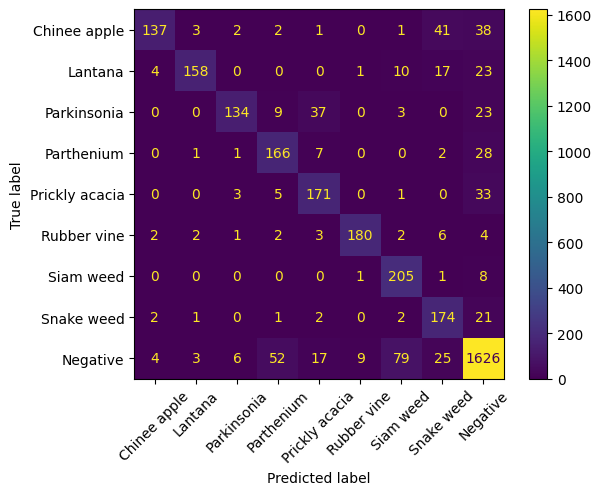

In [29]:
a, b = eval_model(model, test_generator)

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.81622   0.67111   0.73659       225
       Lantana    0.92571   0.76056   0.83505       213
   Parkinsonia    0.90972   0.63592   0.74857       206
    Parthenium    0.69492   0.80000   0.74376       205
Prickly acacia    0.67029   0.86854   0.75665       213
   Rubber vine    0.93684   0.88119   0.90816       202
     Siam weed    0.66775   0.95349   0.78544       215
    Snake weed    0.64444   0.85714   0.73573       203
      Negative    0.92267   0.87150   0.89636      1821

      accuracy                        0.83842      3503
     macro avg    0.79873   0.81105   0.79403      3503
  weighted avg    0.85563   0.83842   0.84082      3503


                False Positive Rate  Accuracy
Chinee apple               0.010372  0.671111
Lantana                    0.003951  0.760563
Parkinsonia                0.003943  0.635922
Parthenium                 0.021831  0.800000
Prickly acacia    

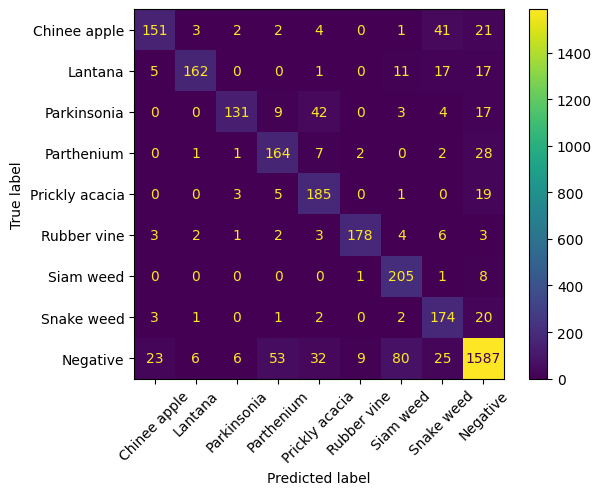

In [30]:
printStats(a,b,0.11)

## Clear Files

In [31]:
shutil.rmtree(base_dir)